In [1]:
import numpy as np
import pandas as pd
import re
import glob #this makes a list of all the files in a directory
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import *

In [2]:
with_gender = pd.read_pickle("WithGenderFinal.p")
with_gender['gender'].value_counts()
line_column=[]
for i in with_gender.index:
        line_column.append(' '.join(with_gender['Speech'][i]))
with_gender['Line']=line_column

length_column=[]
for i in with_gender.index:
        length_column.append(len(with_gender['Line'][i].split()))
with_gender['linelength']=length_column

with_gender_dum = pd.get_dummies(with_gender['gender'])
with_gender = pd.concat([with_gender, with_gender_dum],axis=1).drop(['F','gender'],1)

In [3]:
with_gender_sort = with_gender.sort_values(by=['Title','LineID'])
with_gender_sort = with_gender_sort.reset_index(drop=True)

In [4]:
to_male_column=[]
to_female_column=[]
for i in with_gender_sort.index:
    if i+1 < len(with_gender_sort) and (with_gender_sort['LineID'][i]+1)==with_gender_sort['LineID'][i+1]:
        if with_gender_sort['Char'][i]!=with_gender_sort['Char'][i+1]:
            if with_gender_sort['M'][i+1]==1:
                to_male_column.append(1)
                to_female_column.append(0)
            if with_gender_sort['M'][i+1]==0:
                to_male_column.append(0)
                to_female_column.append(1)
        else:
            to_male_column.append(0)
            to_female_column.append(0)
    else:
        to_male_column.append(0)
        to_female_column.append(0)
with_gender_sort['ToMale']=to_male_column
with_gender_sort['ToFemale']=to_female_column

In [5]:
with_gender_sort.head(n=50)

,Char,Title,Genre,pkey,LineID,Speech,Line,linelength,M,ToMale,ToFemale
0,ALLEN,12,Comedy,allen-12,7,"[Okay...hold on. Yeah I'll take care of, you i...",Okay...hold on. Yeah I'll take care of you in ...,14,1,0,0
1,ALLEN,12,Comedy,allen-12,9,"[Hello.? Yeah okay I've got somebody else, on ...",Hello.? Yeah okay I've got somebody else on ho...,22,1,0,0
2,ALLEN,12,Comedy,allen-12,12,"[Okay, oh doctor.]","Okay, oh doctor.",3,1,0,0
3,ALLEN,12,Comedy,allen-12,14,[Are you there?],Are you there?,3,1,0,0
4,ALLEN,12,Comedy,allen-12,16,[Can I use my real name on the radio?],Can I use my real name on the radio?,9,1,0,0
5,ALLEN,12,Comedy,allen-12,18,"[First of all I'm invisible. I see, myself loo...",First of all I'm invisible. I see myself looki...,19,1,0,0
6,ALLEN,12,Comedy,allen-12,20,"[And the next thing you know I'm, getting marr...",And the next thing you know I'm getting marrie...,14,1,0,0
7,ALLEN,12,Comedy,allen-12,22,[Like an entire solid month.],Like an entire solid month.,5,1,0,0
8,ALLEN,12,Comedy,allen-12,24,"[Then all of a sudden I see myself, walking do...",Then all of a sudden I see myself walking down...,15,1,0,0
9,ALLEN,12,Comedy,allen-12,26,"[Can you hold on for one second..., Hello.]",Can you hold on for one second... Hello.,8,1,0,0


In [6]:
with_gender_long=with_gender_sort[with_gender_sort['linelength']>6]

In [7]:
with_gender_long.head()

,Char,Title,Genre,pkey,LineID,Speech,Line,linelength,M,ToMale,ToFemale
0,ALLEN,12,Comedy,allen-12,7,"[Okay...hold on. Yeah I'll take care of, you i...",Okay...hold on. Yeah I'll take care of you in ...,14,1,0,0
1,ALLEN,12,Comedy,allen-12,9,"[Hello.? Yeah okay I've got somebody else, on ...",Hello.? Yeah okay I've got somebody else on ho...,22,1,0,0
4,ALLEN,12,Comedy,allen-12,16,[Can I use my real name on the radio?],Can I use my real name on the radio?,9,1,0,0
5,ALLEN,12,Comedy,allen-12,18,"[First of all I'm invisible. I see, myself loo...",First of all I'm invisible. I see myself looki...,19,1,0,0
6,ALLEN,12,Comedy,allen-12,20,"[And the next thing you know I'm, getting marr...",And the next thing you know I'm getting marrie...,14,1,0,0


In [8]:
with_gender_long.shape

(158765, 11)

In [9]:
with_gender['M'].value_counts()

1    201934
0     84804
Name: M, dtype: int64

In [10]:
with_gender_long['M'].value_counts()

1    113431
0     45334
Name: M, dtype: int64

In [11]:
print "total male line/gender ratio"
201934.0/(201934+84804)

total male line/gender ratio


0.7042456877009674

In [12]:
print 'total male line/gender ratio for long lines only'
113431.0/(45334 +113431)

total male line/gender ratio for long lines only


0.714458476364438

In [13]:
print np.median(with_gender['linelength'])

7.0


In [14]:
print np.median(with_gender_long['linelength'])

13.0


In [15]:
test_line = "Come here (the hex working now) Oh, well, I see you've been gaining a lot of insight into your... 8 girl powers..."

In [16]:
test_line

"Come here (the hex working now) Oh, well, I see you've been gaining a lot of insight into your... 8 girl powers..."

In [17]:
### try to normalize lines before sending to the model
import re
def preprocess(a):
    regex = re.compile("\((.*?)\)")
    regex2 = re.compile('[0-9]')
    newline = re.sub(regex2, 'NumTok', re.sub(regex, '', a)).lower()
    return newline

print preprocess(test_line)

come here  oh, well, i see you've been gaining a lot of insight into your... numtok girl powers...


In [18]:
with_gender_long['normalized_line'] = with_gender_long['Line'].map(lambda x: preprocess(x))

/home/mathaholic/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
with_gender_long.head()

,Char,Title,Genre,pkey,LineID,Speech,Line,linelength,M,ToMale,ToFemale,normalized_line
0,ALLEN,12,Comedy,allen-12,7,"[Okay...hold on. Yeah I'll take care of, you i...",Okay...hold on. Yeah I'll take care of you in ...,14,1,0,0,okay...hold on. yeah i'll take care of you in ...
1,ALLEN,12,Comedy,allen-12,9,"[Hello.? Yeah okay I've got somebody else, on ...",Hello.? Yeah okay I've got somebody else on ho...,22,1,0,0,hello.? yeah okay i've got somebody else on ho...
4,ALLEN,12,Comedy,allen-12,16,[Can I use my real name on the radio?],Can I use my real name on the radio?,9,1,0,0,can i use my real name on the radio?
5,ALLEN,12,Comedy,allen-12,18,"[First of all I'm invisible. I see, myself loo...",First of all I'm invisible. I see myself looki...,19,1,0,0,first of all i'm invisible. i see myself looki...
6,ALLEN,12,Comedy,allen-12,20,"[And the next thing you know I'm, getting marr...",And the next thing you know I'm getting marrie...,14,1,0,0,and the next thing you know i'm getting marrie...


In [20]:
with_gender_shuffle = shuffle(with_gender_long, random_state = 5)

# Randomly split into training and dev with scikit-learn helper function
train, test = train_test_split(with_gender_shuffle, test_size=0.1, random_state=100)
#dev, test = train_test_split(test, test_size=0.5, random_state=200)

print train.shape
#print dev.shape
print test.shape
print test['M'].value_counts()

(142888, 12)
(15877, 12)
1    11305
0     4572
Name: M, dtype: int64


In [21]:
print "Most Common Class (Baseline) Dev Accuracy:", round(100*(20153.0/(20153+8521)),2)

Most Common Class (Baseline) Dev Accuracy: 70.28


In [22]:
train.head(n=2)

,Char,Title,Genre,pkey,LineID,Speech,Line,linelength,M,ToMale,ToFemale,normalized_line
4702,SIMON,airplane2thesequel,Sci-Fi,simon-airplane2thesequel,32,"[Who would believe that Elaine Thompson wa, on...",Who would believe that Elaine Thompson wa once...,14,1,0,1,who would believe that elaine thompson wa once...
246124,RICA,somethingsgottagive,Romance,rica-somethingsgottagive,738,"[Oh, I love this place called Le Balzar,, it's...","Oh, I love this place called Le Balzar, it's j...",23,0,1,0,"oh, i love this place called le balzar, it's j..."


In [23]:
#train_y, dev_y, test_y = train.M, dev.M, test.M
train_y, test_y = train.M, test.M
train_X = train.drop(['M','Speech','LineID','pkey','linelength'],1)
#dev_X = dev.drop(['M','Speech','LineID','pkey','linelength'],1)
test_X = test.drop(['M','Speech','LineID','pkey','linelength'],1)
test_X.head()

,Char,Title,Genre,Line,ToMale,ToFemale,normalized_line
281510,ROSEN,woodsmanthe,Drama,"Walter, I'd like you to try something for me.",1,0,"walter, i'd like you to try something for me."
47335,CAESAR,bound,Crime,"All these years and you still don't know me, V...",0,0,"all these years and you still don't know me, v..."
261668,DEBBIE,thisis40,Comedy,"Well, it hurts me inside and triggers me that ...",0,0,"well, it hurts me inside and triggers me that ..."
37237,SALLY,bigbluethe,Romance,Oh Jesus...! I'll make some coffee. (starts t...,0,0,oh jesus...! i'll make some coffee. they lef...
241468,BILL,slither,Sci-Fi,He's gotta be in the forest. All three ranches...,1,0,he's gotta be in the forest. all three ranches...


In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Merge
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.utils import np_utils
from keras.layers import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [25]:
NUM_WORDS=20000
from keras.preprocessing.text import Tokenizer
t=Tokenizer(num_words=NUM_WORDS, 
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', 
            lower=True)

t.fit_on_texts(train_X.Line.values)

x_train = t.texts_to_sequences(train_X.Line.values)
x_test = t.texts_to_sequences(test_X.Line.values)
#x_dev = t.texts_to_sequences(dev_X.Line.values)

In [26]:
print train_X.Line.values[1]
print x_train[1]

print train_X.Line.values[2]
print x_train[2]

print test_X.Line.values[1]
print x_test[1]

print test_X.Line.values[2]
print x_test[2]

Oh, I love this place called Le Balzar, it's just a little bistro on the Left Bank, best roast chicken in the universe.
[91, 1, 132, 17, 197, 305, 3746, 7, 6, 35, 5, 109, 20, 3, 238, 942, 259, 5676, 1377, 12, 3, 2098]
Okay, good. Then can I introduce you to my new boyfriend?
[122, 82, 79, 33, 1, 2469, 2, 4, 21, 181, 1347]
All these years and you still don't know me, Violet.
[38, 142, 183, 8, 2, 143, 24, 9, 27, 15, 5288]
Well, it hurts me inside and triggers me that you're such a dishonest shit that you're lending your father money without telling me, while your record company is going bankrupt and we're on the verge of losing our fucking house!
[69, 7, 2144, 15, 406, 8, 15597, 15, 11, 2, 29, 343, 5, 13091, 182, 11, 2, 29, 10931, 25, 223, 199, 277, 526, 15, 278, 25, 830, 663, 14, 67, 11384, 8, 16, 29, 20, 3, 5679, 10, 1374, 111, 186, 194]


In [27]:
maxlen=100
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
#x_dev = sequence.pad_sequences(x_dev, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
#print('x_dev shape:', x_dev.shape)

Pad sequences (samples x time)
('x_train shape:', (142888, 100))
('x_test shape:', (15877, 100))


In [28]:
labels= train_y.values.reshape(-1,1)
#labels_dev=dev_y.values.reshape(-1,1)
labels_test = test_y.values.reshape(-1,1)
print('labels shape:', labels.shape)
print('labels_test shape:', labels_test.shape)
#print('labels_dev shape:', labels_dev.shape)

('labels shape:', (142888, 1))
('labels_test shape:', (15877, 1))


In [30]:
#to get the word embeddings run in terminal:
#wget -O 'PretrainedWord2Vec.bin.gz' "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#gunzip PretrainedWord2Vec.bin.gz

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('PretrainedWord2Vec.bin', binary=True)

In [31]:
word_index = t.word_index
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [32]:
### longer lines only
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

cnn_model_best = Sequential()

#Uses pretrained word embeddings:
cnn_model_best.add(embedding_layer)

cnn_model_best.add(Dropout(0.25))

cnn_model_best.add(Conv1D(10, 3, 
                     padding='valid', 
                     activation='relu',
                     strides=1,
                     input_shape=train.shape))

cnn_model_best.add(GlobalMaxPooling1D())
cnn_model_best.add(Dropout(0.25))
cnn_model_best.add(Activation('relu'))
cnn_model_best.add(Dense(1))
          
cnn_model_best.add(Activation('sigmoid'))

cnn_model_best.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
cnn_model_best.fit(x_train, labels,
          batch_size=32,
          epochs=3,
          validation_data=(x_test, labels_test))

Train on 142888 samples, validate on 15877 samples
Epoch 1/3
142888/142888 [==============================] - 348s 2ms/step - loss: 0.5832 - acc: 0.7161 - val_loss: 0.5627 - val_acc: 0.7215
Epoch 2/3
142888/142888 [==============================] - 339s 2ms/step - loss: 0.5463 - acc: 0.7312 - val_loss: 0.5554 - val_acc: 0.7281
Epoch 3/3
142888/142888 [==============================] - 337s 2ms/step - loss: 0.5203 - acc: 0.7443 - val_loss: 0.5603 - val_acc: 0.7290


In [16]:
### using longer lines only
cnn_model = Sequential()

embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

#Uses pretrained word embeddings:
cnn_model.add(embedding_layer)

cnn_model.add(Dropout(0.25))

cnn_model.add(Conv1D(10, 5, 
                     padding='valid', 
                     activation='relu',
                     strides=1,
                     input_shape=train.shape))

cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(0.25))
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(1))
          
cnn_model.add(Activation('sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
cnn_model.fit(x_train, labels,
          batch_size=128,
          epochs=4,
          validation_data=(x_dev, labels_dev))

Train on 229390 samples, validate on 28674 samples
Epoch 1/4
229390/229390 [==============================] - 149s 650us/step - loss: 0.6051 - acc: 0.7013 - val_loss: 0.5845 - val_acc: 0.7075

In [33]:
### longer lines ony
score = cnn_model_best.evaluate(x_test, labels_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.56029006876152321)
('Test accuracy:', 0.7289790262681618)


In [35]:
with_gender_sort['normalized_line'] = with_gender_sort['Line'].map(lambda x: preprocess(x))
with_gender_sort.head()

,Char,Title,Genre,pkey,LineID,Speech,Line,linelength,M,ToMale,ToFemale,normalized_line
0,ALLEN,12,Comedy,allen-12,7,"[Okay...hold on. Yeah I'll take care of, you i...",Okay...hold on. Yeah I'll take care of you in ...,14,1,0,0,okay...hold on. yeah i'll take care of you in ...
1,ALLEN,12,Comedy,allen-12,9,"[Hello.? Yeah okay I've got somebody else, on ...",Hello.? Yeah okay I've got somebody else on ho...,22,1,0,0,hello.? yeah okay i've got somebody else on ho...
2,ALLEN,12,Comedy,allen-12,12,"[Okay, oh doctor.]","Okay, oh doctor.",3,1,0,0,"okay, oh doctor."
3,ALLEN,12,Comedy,allen-12,14,[Are you there?],Are you there?,3,1,0,0,are you there?
4,ALLEN,12,Comedy,allen-12,16,[Can I use my real name on the radio?],Can I use my real name on the radio?,9,1,0,0,can i use my real name on the radio?


In [54]:
with_gender_long.head()

,Char,Title,Genre,pkey,LineID,Speech,Line,linelength,M,ToMale,ToFemale,normalized_line
0,ALLEN,12,Comedy,allen-12,7,"[Okay...hold on. Yeah I'll take care of, you i...",Okay...hold on. Yeah I'll take care of you in ...,14,1,0,0,okay...hold on. yeah i'll take care of you in ...
1,ALLEN,12,Comedy,allen-12,9,"[Hello.? Yeah okay I've got somebody else, on ...",Hello.? Yeah okay I've got somebody else on ho...,22,1,0,0,hello.? yeah okay i've got somebody else on ho...
4,ALLEN,12,Comedy,allen-12,16,[Can I use my real name on the radio?],Can I use my real name on the radio?,9,1,0,0,can i use my real name on the radio?
5,ALLEN,12,Comedy,allen-12,18,"[First of all I'm invisible. I see, myself loo...",First of all I'm invisible. I see myself looki...,19,1,0,0,first of all i'm invisible. i see myself looki...
6,ALLEN,12,Comedy,allen-12,20,"[And the next thing you know I'm, getting marr...",And the next thing you know I'm getting marrie...,14,1,0,0,and the next thing you know i'm getting marrie...


In [55]:
### all lines 
with_gender_shuffle = shuffle(with_gender_sort, random_state = 5)

# Randomly split into training and dev with scikit-learn helper function
train, test = train_test_split(with_gender_shuffle, test_size=0.1, random_state=100)
#dev, test = train_test_split(test, test_size=0.5, random_state=200)

print train.shape
#print dev.shape
print test.shape
print test['M'].value_counts()

(258064, 12)
(28674, 12)
1    20153
0     8521
Name: M, dtype: int64


In [56]:
### all lines
with_gender_shuffle = shuffle(with_gender_sort, random_state = 5)

# Randomly split into training and dev with scikit-learn helper function
train, test = train_test_split(with_gender_shuffle, test_size=0.1, random_state=100)
#dev, test = train_test_split(test, test_size=0.5, random_state=200)

print train.shape
#print dev.shape
print test.shape
print test['M'].value_counts()

(258064, 12)
(28674, 12)
1    20153
0     8521
Name: M, dtype: int64


In [66]:
#train_y, dev_y, test_y = train.M, dev.M, test.M
train_y, test_y = train.M, test.M
train_X = train.drop(['M','Speech','Line','LineID','pkey','linelength'],1)
#dev_X = dev.drop(['M','Speech','LineID','pkey','linelength'],1)
test_X = test.drop(['M','Speech','LineID','Line','pkey','linelength'],1)
test_X.head()

,Char,Title,Genre,ToMale,ToFemale,normalized_line
13071,GEORGES,amour,Romance,0,0,"i'll do that tomorrow morning. anyway, they di..."
193640,PAULA,myweekwithmarilyn,Drama,0,0,but marilyn is not ready. she's preparing.
273222,WALTER,visitorthe,Crime,0,0,damn it!
45675,ROMEO,boondocksaints2allsaintsday,Crime,0,0,too sacrilegious.
194304,FERRIS,next,Sci-Fi,1,0,that's why i need your people. everybody else ...


In [67]:
train_X.head()

,Char,Title,Genre,ToMale,ToFemale,normalized_line
8265,JACK,allthekingsmen,Drama,0,1,answer me!
87408,CLIFTON,englishpatientthe,Romance,1,0,isn't it? wedding present from katharine's p...
134065,INDY,indianajonesandtheraidersofthelostark,Adventure,0,0,don't do that. it scares me.
27134,CLAUDIA,avventuraltheadventure,Mystery,1,0,anna! . . . anna!
94155,GUS,faultinourstarsthe,Romance,0,1,"on the other hand... we need closure, don't we..."


In [69]:
### all lines
NUM_WORDS=20000
from keras.preprocessing.text import Tokenizer
t=Tokenizer(num_words=NUM_WORDS, 
            filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', 
            lower=True)

t.fit_on_texts(train_X.normalized_line.values)

x_train = t.texts_to_sequences(train_X.normalized_line.values)
x_test = t.texts_to_sequences(test_X.normalized_line.values)
#x_dev = t.texts_to_sequences(dev_X.Line.values)

In [70]:
### all lines 
maxlen=100
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
#x_dev = sequence.pad_sequences(x_dev, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
#print('x_dev shape:', x_dev.shape)



Pad sequences (samples x time)
('x_train shape:', (258064, 100))
('x_test shape:', (28674, 100))


In [71]:
### all lines
labels= train_y.values.reshape(-1,1)
#labels_dev=dev_y.values.reshape(-1,1)
labels_test = test_y.values.reshape(-1,1)
print('labels shape:', labels.shape)
print('labels_test shape:', labels_test.shape)
#print('labels_dev shape:', labels_dev.shape)

('labels shape:', (258064, 1))
('labels_test shape:', (28674, 1))


In [73]:
### all lines
print train_X.normalized_line.values[1]
print x_train[1]

print train_X.normalized_line.values[2]
print x_train[2]

print test_X.normalized_line.values[1]
print x_test[1]

print test_X.normalized_line.values[2]
print x_test[2]

 isn't it?  wedding present from katharine's parents.  i'm calling it rupert bear.  hello.  geoffrey clifton.
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0   203     9
     7   868  1021    71  6951     6   679     2    20   680     7  3175
  1151   250 10829  8223]
don't do that. it scares me.
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   

In [75]:
### all lines
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('PretrainedWord2Vec.bin', binary=True)

In [76]:
### all lines
word_index = t.word_index
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [77]:
### longer lines only
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

cnn_model_all = Sequential()

#Uses pretrained word embeddings:
cnn_model_all.add(embedding_layer)

cnn_model_all.add(Dropout(0.25))

cnn_model_all.add(Conv1D(10, 3, 
                     padding='valid', 
                     activation='relu',
                     strides=1,
                     input_shape=train.shape))

cnn_model_all.add(GlobalMaxPooling1D())
cnn_model_all.add(Dropout(0.25))
cnn_model_all.add(Activation('relu'))
cnn_model_all.add(Dense(1))
          
cnn_model_all.add(Activation('sigmoid'))

cnn_model_all.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
          
cnn_model_all.fit(x_train, labels,
          batch_size=32,
          epochs=3,
          validation_data=(x_test, labels_test))

Train on 258064 samples, validate on 28674 samples
Epoch 1/3
258064/258064 [==============================] - 656s 3ms/step - loss: 0.5928 - acc: 0.7064 - val_loss: 0.5782 - val_acc: 0.7118
Epoch 2/3
258064/258064 [==============================] - 657s 3ms/step - loss: 0.5685 - acc: 0.7158 - val_loss: 0.5737 - val_acc: 0.7154
Epoch 3/3
258064/258064 [==============================] - 657s 3ms/step - loss: 0.5546 - acc: 0.7227 - val_loss: 0.5730 - val_acc: 0.7167


In [78]:
### longer lines ony
score = cnn_model_all.evaluate(x_test, labels_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.57301994084546926)
('Test accuracy:', 0.71671200390597756)


In [79]:
predictions = cnn_model_all.predict_classes(x_test, batch_size=1000)

In [80]:
probabilities = cnn_model_all.predict(x_test, verbose=1)

28674/28674 [==============================] - 4s 149us/step


In [81]:
probabilities
print np.mean(probabilities)
print np.std(probabilities)

0.707063
0.134108


In [82]:
from sklearn.metrics import confusion_matrix

y_pred = probabilities > 0.5

confusion_matrix(labels_test, y_pred)

array([[ 1041,  7480],
       [  643, 19510]])

In [83]:
labels_test

array([[1],
       [0],
       [1],
       ..., 
       [0],
       [1],
       [0]], dtype=uint8)

In [84]:
binarized_pred = probabilities.round()

In [86]:
wrong_probs=[]
lengths_corr_fem=[]
print "Correctly Labeled as Female:"
for i in range(len(binarized_pred)):
    if int(binarized_pred[i]) == 0 and int(labels_test[i])==0:
            #print "correct call"
            print test_X.Char.values[i], ": ", test_X.normalized_line.values[i], "\n"
            lengths_corr_fem.append(len(test_X.normalized_line.values[i].split()))
    elif int(binarized_pred[i]) != int(labels_test[i]):
        #print "Incorrect prediction: called %s instead of %s, %3.4f sure" % (binarized_pred[i], labels_dev[i], probabilities[i])
        #print dev_X.Line.values[i]
        wrong_probs.append(probabilities[i])

print np.mean(wrong_probs)
print np.mean(lengths_corr_fem)

 Correctly Labeled as Female:
BETH :  if you promise to love me and be committed to me - numtoknumtoknumtok 

ANNA :  alexei!--you got away at last. can you stay? 

MARIANNE :  but edward loves you. 

VADA :  you don't have to wait, daddy'll be mad if you're late. 

UGGA :  what? grug! 

ELLEN :  would you like something? some coffee 

SAWSAN :  sa'ad has disappeared. his wife, his children are missing. my uncle in mansour. he said they were targeting them. they were killing them.. 

ELLA :  mumble? 

KARA :  danny!!! 

NICOLE :  that's not what i meant. you should tell everyone what you just told nick behind the set. 

JUDIT :  ernesto hired various detectives to search for you, b before they found you, you called me, two days after the premier.  i was too embarrassed to answer, and... too stunned. i still am when ernesto senior asked me again about you, i don't know why, i gave him the phone number for famara... 

TATUM :  is that you, randy? cute. 

CAROL :  look, larry. all i know 


JENIFER :  good morning, mr. parrish. 

MARIA :  actually, i'm probably gonna work out a little bit, clean up the apartment, and then go over to my boyfriend's place. he's cooking me a really nice dinner. 

GABRIELLE :  hmmph. hmmph.  nathan, we have to talk, you and i. 

VALERIE :  adapting someone else's work is certainly an opportunity to think differently. 

BELLA :  no, edward!    don't! 

JENNY :   i'm not sleepy anymore. let's drive for a little while longer. 

MARILYN :  he wanted me to find it. it said he should never have married me. that i was unpredictable and a woman-child, flighty and self- centred. he's left me, colin. why do the people i love always leave me? 

MURIEL :   ...jim? 

SANDRA :  howard, don't. you'll embarrass me. 

JULIE :  hello? oh, hutch - what? 

ROBERTA :  i wouldn't put it that way... you all just need to practice a bit more.  james, have you practiced this week? 

NINA :  do you have a minute? he doesn't answer, just opens the door to the office an

ELENA :  my husband is probably passed out in the bathroom, or at least he wishes he were. i've been married to him for numtoknumtok years and i don't have any intention of going in there to get him... so what i'm proposing is that since your wife has gone off with a boy, and since you are standing here alone, i'm proposing that you and i do what makes sense. stay warm. pass some time. that's all. 

EUNICE :  cuz, tonight...mamma's right on time. 

HILLY :  pie's as good as always, minny. 

BETTY :   now, ted, wait a minute. i know you're freaked, i know you're stressed. you've had a real bad night -- 

JACKIE :  fine, forget it. but neither of them wants her to.  a mexican standoff.  until jackie empties her huge purse on the counter. 

ALMA :  fine, darling. i'll save you a seat. 

ASTRID :  the black sheep! come on, stormfly! we can still win this thing! 

LANDLADY :  oh, well. don't worry, hon. he probably just went away for the holidays. numtoknumtok. 

SISSY :  why the fuck did y

In [88]:
lengths_inc_female=[]

print "Incorrectly Labeled as Female:"
for i in range(len(binarized_pred)):
    if int(binarized_pred[i]) == 0 and int(labels_test[i])==1:
            print test_X.Char.values[i], ": ", test_X.normalized_line.values[i], "\n"
            lengths_inc_female.append(len(test_X.normalized_line.values[i].split()))
print np.mean(lengths_inc_female)

 Incorrectly Labeled as Female:
BAINES :  keite pail kaare e titahataha aria.  

BEN :  but dad, you guys truly hated each other, i mean really hated each -- 

QUINN :   quinn.  zoey? interesting. 

COLIN :  which one is which? she bursts out laughing. her eyes sparkle and she looks captivating in the glistening lights. he goes to kiss her and this time she doesn't stop him. colin's bristol is drawn up in a quiet suburban road lined with pleasant semi-detached houses. lucy's house has a neat patch of front lawn, a stolid family car in the drive and net curtains in the windows. it is very little different from any of its neighbours. 

RICK :  you're absolutely right. i should never have stopped to save that drowning infant. i'm just weak, sister; i'm so weak. 

ALFREDO :  i've shown it so many times i know it by heart. the first time i showed it, in numtoknumtoknumtoknumtok, was the sunday my first wife died. they kept it hidden from me all day so they wouldn't have to close down the mo

OLIVER :  how do you keep hold of friends... or boyfriends? 

LUKE :  partly.  but partly, you're mad. staring.  at each other. 

PADICHE :   "pushy?" numtoknumtok. 

MICAH :  olive! olive penderghast! 

GRU :  kevin, jerry, watch the girls for me, okay?  dave, stuart--come this way. with me! come on! 

CARLISLE :  edward -- 

YURI :  this is a love song, a soldier's song to his beloved -- alexei, he's afghanstya, a veteran of afghanistan. he saw terrible things. 

DEVON :  kirk said she likes his taurus. 

WILLOUGHBY :   how do you do, miss marianne? 

EDDIE :  it's a convent.  all you have to do is shut up, behave yourself, and get along. 

LARRY :  jeff murray. the guy i've been talking about. hello? 

CRIS :  well, i was, as they say, left on a doorstep when i was two.  never found foster parents who could put up with me. - so to me, a family sounds like plenty. 

BOYD :  you want some breakfast meat, michael is that what you want? 

VICTOR :  i'm worried about you. 

JEEP :  you s

In [89]:
lengths_inc_male=[]

print "Incorrectly Labeled as Male:"
for i in range(len(binarized_pred)):
    if int(binarized_pred[i]) == 1 and int(labels_test[i])==0:
            print test_X.Char.values[i], ": ", test_X.normalized_line.values[i], "\n"
            lengths_inc_male.append(len(test_X.normalized_line.values[i].split()))
print np.mean(lengths_inc_male)

Incorrectly Labeled as Male:
PAULA :  but marilyn is not ready. she's preparing. 

FERRIS :  that's why i need your people. everybody else is assigned. 

ELLEN :   sometimes people need to see things done for them -- because sooner or later they don't believe the words anymore. 

JULIENNE :  in maine, it's been frozen for two months. 

TIFFANY :  i just hope you can handle it. 

ANGELA :  you okay, lady? 

NANCY :  yeah, yeah, i ' d like that -- 

CHRISTMAS :  doctor. jones. christmas jones. no jokes, i've heard them all. 

ROBERTA :  your buddies giving you a hard time? 

CAROL :  oh. 

APOC :  no way.  not possible. 

ANGELA :  your mom's the one who's embarrassing. what a phony. 

TERRI :  you're apologizing? 

OLIVE :  but i'm already finished. except for my helpful and profane peas. 

JODY :  you want it? 

LORRAINE :  when you were about eight...you suffered night terrors. awful fits of pure fear. you were terrified of an old woman who you said would come to visit you at night. 


CLAIRE :  and "is"...? 

SUSAN :  tell me you love me -- tell me you love me now -- 

LAURA :  huh. 

SUZANNE :  why not? 

ENGLAND :  flea!  'cool!  o'neil!  cortez! slutnik!  in that order!  five- second intervals!  let's go! 

JO :  don't worry, i'm not gonna make a motion for separation, you're still lead counsel. 

MAYA :  oh. you mean... today? 

MARY :  not for me. numtoknumtok 

KRIS :  grandma i love you. 

COREY :  she's right... 

BARTENDER :   you sure...? 

ELIZABETH :  no. he wouldn't remember. 

LENA :  numtoknumtok excuse me, i am retiring to my room. 

CLEAR :  my family is dead.   my friends are dead. and alex... 

LORI :  good. 

ZOEY :  [let go of me you shit!!] 

GINA :  you're blaming me? i had to go see my family. 

MARILYN :  don't spoil it. 

TAMARA :  on the wasp. you told me where it laid, just before you passed out. though i can't say as i feel much safer here. 

EVEY :  but i could feel it. 

JULIANNE :  uh.  how about promoting a bridesmaid?  someone you k

DEBBIE :  debbie. i always though i looked like sandra dee. 

GINGER :   i told you i was hot tonight. 

RENAI :  well can you pick them up after school? 

JILL :   does this mean a raise? 

ANDREA :  now your father may seem sleepy to you, but that's just because of his medicine, okay? 

NADIA :  i don't have nothing. 

JENNIFER :  you've taught me a lot. 

ERICA :  you've been drinking. 

SAMMY :  i'm not thr -- you explore it. i'm going back to work. 

TABBY :  we will. i promise. 

MARTHA :  no! 

ELSPETH :  you stay outta this! 

MARION :  why start now? 

ET :  if those quarters fell to the floor, would you still reach up to that cash register? 

MACE :  get in here.  come on lenny, move it.  move!! 

ANNA :  yeah. i'm gonna stay here with my new friend . 

STARCK :  hurry. 

CLARA :  but i hate putting you to that trouble. 

JO :  i'm just saying go slow. 

JODI :  a dick. 

CHARLOTTE :   good. 

LINDY :  what. what. 

DEBBIE :  hey desi, would you mind wearing some of the cloth

HEDRA :  yeah, i never know what looks good. 

BETH :   fuckin' nick... 

CASEY :  yes! 

DEBBIE :  what? 

JO :  thank you. 

CHARLOTTE :  once upon a time, there was a woman on a ship crossing the atlantic and her little boy got sick. very sick. and she said whoever saves my boy's life... i'll name my next baby after them. well, they got into port and they rushed her son to st. vincent's hospital... to here... and they saved his life. and so the mother named her next baby edna st. vincent millay.  and edna grew up to be, as i am sure you know, the second greatest female poet in american history. 

MAGGIE :  to who?  are you asking me? 

OLIVE :  i'll help you out. i don't have anyone to call. i haven't watched 

GIGI :  i am so almost done with that. it's just been a little hard to focus on my article about the two sets of twins in market research, when the guy - who may or may not be the guy of my dreams - refuses to call me. numtoknumtok 

LULL :  it the pope martian? 

DIL :  okay


MIA :  i don't know.  perhaps he'll become a knight. 

NADIA :  i'll kill you if you try. 

FERRIS :  then give me another chance. you get `em all the time. 

DEHAVEN :   high-school pentathlete... rotc scholarship, graduated with honors... top marks in basic training... and, as it just so happens, a constituent of my home state of virginia.  oh, the things i'll do for one extra vote. 

EMILY :  hi. 

CAROL :  honey, i'm here. i'm right o... 

RHIANNON :  we're speaking present day. i mean, jesus, mortimer was probably a sexy name in some era. 

ANNA :   ...yeah. now come on. this way to the north mountain? 

KIT :  bullshit ! 

SUPERGIRL :  you could do anything. you could sculpt 

SUSAN :   go away!...go away!... 

JENNY :  i don't know. 

JO :  i need an answer to my question, sir. 

GRUSINSKAYA :  good morning, pimenov. 

NINA :  what is it? 

CARLA :  lina, come here! 

MARGARET :  don't leave me. 

HANA :  i'm sorry.  i forgot you'd be worrying. we're all safe.  it was a mine, b

VADA :   carnnk yu sheeee ik?? 

SHELLY :   we? 

ANNIE :  stop it!  don't ... don't do that!  there. 

RUTH :  you used his credit card. 

CARRIE :  tommy... why? 

SARAH :   lieutenant, are you sure it's them?  maybe i should see the ...bodies. 

MICHELLE :  well, if you think my brother's such a "joke," how much better could you think of me? we're not that different, you know? 

COUNTESS :  never. 

WAVEY :  i know you have to stay tomorrow. to sign the papers. but. 

SKEETER :  ah...yule may was just telling me how excited she was that her boys were going to go to college. 

CHARLOTTE :  can i go show them my crystals before they leave? 

ANN :   go. keep on his good side. he set up arizona. 

SISSY :  why the fuck not? 

ALLISON :  do we have any yogurt left? 

TIFFANY :  december twenty-eight, last game of the season. 

ANNABELLE :  and bring my knees up, hard, yeh? 

RUTH :  sam is sam. he's taking up fly fishing. he's in a yert in montana. 

RHONDA :   i don't control the weath

JODY :  take her picture. c'mere. 

LINDSEY :  none other. 

JENNY :   even if we walk five miles, it's not going to make any difference. 

BREE :  bree daniel.  oh yes, ted carlin, how is ted? oh, well, thank you very much but maybe the next time you're in town  well i just love ted and i'd love to meet you -- you have a very nic voice -- but i just --  well i'm having a chat with a very nice cop. actually not a real cop; he's a private inves -- 

ZOE :  come on. use the gas, not the brake, numtok-numtok. numtoknumtok. 

JOHANA :  but... how is he going to breathe? 

RUTH :  shit! numtoknumtok. 

SHEELER :  that's true. 

MARIA :  no. 

JUNIPER :  wait. numtoknumtok. ellis turns and watches may pearl push a cart in the parking lot with her family. neckbone bangs at the coke machine. 

ROXANNE :  they broke the mold. 

MARY :   if you need me, i'll be -- 

ISABELLA :   is this the protective male talk? 

JOHANA :  right chief! 

RAZIEL :  as below, so above.  you hold the univers, will

MOLLY :  hello? 

RUTH :  kirshner does not apply. kirshner was in kentucky. 

MOTHER :  but we must respect that power, we must be in awe of it. 

MARY :  well, what should we do? 

ROXANNE :   ...yes.  i mean, excuse me? 

ADRIAN :  oh, rocky! 

JO :  the witness has rights. 

CAT :  if you do, you would never have let me get involved in the first place. 

JORDAN :  thank you, sir.  but i expect a certain amount of pain. 

ARLY :   come in. 

SLOAN :  no shit!  we're gonna set up a monitor on a garbage dump!  so we can monitor garbage rusting? 

MAGGIE :   how do i do it?  i'm not that beautiful 

JANINE :  oooh, gimme the signs.   i love to hear about the signs. 

RENATA :  are we allowed to park here? 

LYNN :  think so, in our bed... she's funny. 

SECRETARY :  oh, the scuttlebutt for awhile was he was investigating kennedy-- 

ROXANNE :  great. how does the park sound, around noon-ish? 

CHRISTINE :  the morning? but...wait, i've got to talk to someone in authority -- 

MONICA : 

JOAN :  you know the business. you know the clients. you actually care about your job. you'd be perfect. numtoknumtok. cedar rapids, numtok-numtoknumtok-numtoknumtok 

CARRIE :  wrong! i was willing to do whatever it took to get you up off your ass and on the way to california... there's a big difference. 

PAULA :  you can do it. you can't fail. you will have more pain, you will suffer more but you will create. all you need is time. 

KIMBERLY :  i have to do this. 

NATASHA :  you didn't come here because i bat my eyelashes at you. 

LUCY :  thank you.  goodnight. 

CASS :  nothing. i had her add mayo to your burger. i remember you like that. 

PRINCESS :  when we... did you think of her? 

MARION :  bought and p-p-paid for. just like one of his goddamn statues. well at least in the movie he married her! 

JOHANA :   remember when i went to italy and canceled the policy on the new stadium.  well, we weren't being cheated by the mafia or anybody except maybe by me...  ... do they come


DELLA :  he's on fire. 

NEEDY :  those guys are rank, jen. just forget about it. 

LORI :  that's my ringtone? 

CROWNE :  i take it you've heard the news. 

LIDEWIJ :  i also think the earth is round. 

JULIA :  good night, dad. 

ELSA :  oh, anna...no...no, please no. 

ELIZABETH :  who? victor? 

RAMONA :  sure. 

ROBERTA :   that is so beautiful! 

JULIA :  we went to say hello to granny. 

CLAIRE :  don't let us stand in the way. 

GABRIELLE :   you're kidding! holy shit.  yeah, no duh! i had a wild hair up my ass over that for a month. 

ELLEN :  c'mere... 

JUDGE :  you'd recently been offered a promotion. why did you prefer to join the ss? 

NORA :  come on, tim, lights out already. 

ALICE :  he was just inviting me to a party 

CHRISTY :  middle section, hold that note, for dear life.  sopranos, an a.  sister alma? 

JUDY :   girls don't love their father? since when?  since i got to be sixteen? 

JAMIE :  prove it. 

BO :  i want spaghetti? 

LINDA :  that little prick. 



SAMMY :  oh... it's just the hormones. 

SAM :  oh... how did it happen? numtoknumtok. 

LUISA :  i'm staggered by my own stupidity. could vomit. 

PEGGY :  good morning to you, too.  you look goo 

MARY :  go around him. 

ROSE :  i fell madly in love with him when he called me rosebud. you know that first day when i come and he said i looked graceful like a capital letter s and called me rosebud? i fell madly in love with that man right then.  but it's a lost love, buddy. he's a good man and won't have nothin' to do with me. 

LUCILLA :  you're right. 

KATE :  i don't really remember, but i'm sure you were. most people are. 

RENEE :  it is? 

ANGIE :  dale? 

ROSE :  my brother says the guy's a thirty- five year old virgin, so maybe he won't know how women usually feel. plus he's got bad eyesight, almost legally blind, which is helpful in this situation. plus he's got an extremely small penis, of which he is "mortifyingly ashamed", so chances are he'll be so grateful for any non- j

GRACE :  the kids were so bright, so eager to learn... they picked up english faster than i could teach it to them. 

SUSAN :  don't get dirty, dad -- 

ANNE :  he wasn't like anybody i ever knew before. 

AUDREY :  jerry. his name is jerry and yes, he's going. 

DEBBIE :  just put it in the trash. 

ERICA :  it was interesting. so... good night. 

NAOMI :  tiny dogs. the technology's not perfect. seeing a horse the size of a can of soup fall dead before your eyes - that shit stays with you. 

MARGO :  a married lady. 

MOM :  oh no, the prodigal son's home.  we bring out the store bought. 

ROBERTA :  yes you were but you weren't paying attention! do you want people to think you're stupid? 

JILL :  well, i'll be here -- i always like what you do. 

SUSAN :  have you seen mum yet? 

COLLINS :   is there something else, norma? 

JUNO :  i was thinking a graphic designer, mid-thirties, and his cool asian wife who dresses awesome and plays bass. but i'm trying to not be too particular. 


AIBILEEN :  soon after, that bitter seed inside of me had sprout and was growing fast... 

JENNY :   i can't. i'd like to help. you look like scott, but i know you're not. i don't know what you are. you gotta understand, i'm afraid of you... 

ROBERTA :  great! 

ANNIE :  what? 

JEANNE :  my cousin paul. my first love. 

PAMELA :  don't be preposterous. 

EMILIE :  today we learn to jump. did you know the french cleared one meter eighty- five at the paris olympics to win the gold medal? today we will beat that record. 

HEATHER :  why not? 

DEBBIE :  let's go. everyone inside. 

NELL :  well, are you ready to go? 

SAM :  doesn't look too good... 

CELIA :  i almost forgot the dessert. 

WANDA :  we'll pause to set this light and go again right away. how long, wolf? 

ALISON :  hi. 

NIKKI :  yes, this is where nikki lives. 

JANET :  i don't have the power here, roberta. i'm so sorry. 

ROSE :  he's killed him, anderson! 

HUNSECKER :  mr. falco, let it be said at once, is a man of 

In [90]:
lengths_corr_male=[]

print "Correctly Labeled as Male:"
for i in range(len(binarized_pred)):
    if int(binarized_pred[i]) == 1 and int(labels_test[i])==1:
        print test_X.Char.values[i], ": ", test_X.normalized_line.values[i], "\n"
        lengths_corr_male.append(len(test_X.normalized_line.values[i].split()))
            
print np.mean(lengths_corr_male)

Correctly Labeled as Male:
GEORGES :  i'll do that tomorrow morning. anyway, they didn't see anything. 

WALTER :  damn it! 

ROMEO :  too sacrilegious. 

PLOG :  hang on to something, my friends. the hour is near! who is that at the edge of the forest if not my own dearly beloved, with actor attached? 

TIMMY :  gaff rigged? why not a staysail schooner? go anywhere. look at this the mayan, an alden schooner. 

MORTIMER :  then i must be here. 

WALTER :  try. 

ROMEO :  how would you like me to sidekick you in the ass, roy? numtoknumtok. 

BILLY :  what did you do when you were little? 

ELLIOT :   

WARDEN :  i wanted to -- i tried -- but i couldn't... 

LENNY :  thanks, max.  i'm touched by your concern. 

DAGGETT :   where? 

CORIN :  more wood boy! we must test the steel with our fire. 

STAINER :  you dick! 

SKIPPER :  you're officer of the watch, george. 

KROD :  i got a lock. coordinate numtoknumtoknumtoknumtoknumtok! 

CORNWALLIS :  gentlemen, celebration is premature. we ha

TREVOR :  please, gwen. you're- you're all over me. 

O'CONNELL :  keep an eye on her. if you leave her door, i'll rip your spleen out. c'mon, jonathan. 

BILLY :  do they all come in and cry...your cops? 

MIKEY :  i don't ever want to see you. 

BOND :  let it blow. 

COBB :  what?! 

WEST :  it's going to be a long flight. 

TIMOTHY :  no. you don't.  i can always tell, you know... if someone's lying to me. a little skill of mine, something to trot out at parties. 

DOUG :  horrible bastard, it's his fight, made all his money in. he touches the side of his nose and inhales. 

JARED :  bella swan.    who else? 

AARON :   you want a smack? i am seriously gonna smack yer ass. 

PERCEVAL :  excellent.  for the next four months you never leave her side, day or night. there will be crowds. 

HAN :  wonderful girl! either i'm going to kill her or i'm beginning to like her. get in there! 

BRANDON :  only an idiot would follow him after the streak i've been on. 

VIJAY :  oh yes... love to

LANDO :   okay, let's go. 

HARRY :  okay, okay. let's not get goofy. we got no thin , but good news here. 

PHIL :  that's not a will barbara, and you know it. 

MUMBLE :  aliens?! 

CORRADO :  that's patrizia's way of letting us know she's with us. 

ANDREW :   what type of camera is that? 

NICK :  oh, ok; i guess i missed it. you could make it bigger if you want. and ellen, maybe just a little more tension when you see him. 

TAYLOR :  okay, let's get nasty here, rick. you know he's lookin' for this pitch. gotta come up with somethin' studly. 

KUMAR :   okay, where was i? oh yes. more symptoms of pancreatitis. um...decreased bowel sounds, possibly fever, dehydration, and sometimes even shock. 

JUDGE :  where in government? 

DRUMMOND :  her operation -- that is to say, mrs. mangafranni's operation -- was not scheduled until nine-thirty. so at nine-fifteen this morning, i rang for my nurse... 

PHIL :  c 

PETE :  hey! 

JACOB :  he's going for it. we're almost home. 

JONES :  li

ALFREDO :  these are the shipping invoices for the film. they are always to be kept. you see? 

DANNY :  i've been stuck out in the country with those guys who just want to paint swastikas and heil hitler. how am i supposed to --  

JACQUES :   you're the best, enzo! 

ALEX :  my cable's out. 

BILLY :  what did they offer? 

CHIP :   eye-talian. 

MCCALL :  another negotiator is on his way. 

ROBIN :  yield to robin hood. 

SARGENT :   molly's first present i-i-is...mrs. potato head.  repeat.  a mrs. potato head. 

DEWART :  what do you mean? 

CURTIS :  there we go. all right. keep it out of your eyes. okay? 

PERRY :  what happened? 

HOWARD :  yes sir. 

HOMER :  you know what? i did. 

EREK :  did she say anything? 

CLAUDE :  an erection, huh? haven't had one of those in a while. 

EDDIE :  it's just a question, vern. 

DONNIE :  . i ' m an undercover agent for the 

EDDIE :  he'll be back! 

HECTOR :  no sign of a battle... only a few horses... or just one. he wasn't killed in a

CARL :  what are you doing out here, kid? 

BUD :  i'm tying up loose ends.  padding my report.  you know how it goes. 

DUDE :  uh-huh. 

PEDRO :  koufax is okay... but tippy martinez, he is the best... he pitches for the baltimore orioles, and some day i will be the second man from nicaragua to play in the major leagues... 

JACK :  well, things seem to have quieted down. 

PANCAKE :  they back yet? 

TED :   screw driver! 

DAD :  what's going on? 

COLIN :   douchebag! 

PAPPAS :  sure.  no problem.  how about your office?  your office need vacuuming? we could do that too. 

DALE :  what is this? it's spectacular. 

BASQUIAT :  andy, man, thanks for coming. i'd like to paint your jacket. 

WALTER :  sorry. 

LEO :  she said to tell you, she's with friends, and she's fine. 

ARTHUR :  can i call you? 

SKIPPER :   who the hell do they think they are? 

PLAGUE :  sh, sh sh sh sh. 

WEST :  no. 

OLIVER :  ...generally by the time you are real, most of your hair has been loved off, an

EDWARD :  it's just that, uh, very few people surprise me. 

CORBETT :  look, take these cuffs off.  we need to work together. 

FERGUS :  what was that? 

MURPHY :  okay. just calm down. take it easy. he'll have his day. he'll have his  

LOUIS :  what is wrong?! 

ADDISON :  more plainly and more distinctly? i have not come to new haven to see the play, discuss your dreams, or to pull the ivy from the walls of yale! i have come to tell you that you will not marry lloyd - or anyone else - because i will not permit it. 

KRINGELEIN :   oh -- doctor -- you are a doctor -- i am -- 

MURDOCK :  we are turning left to a heading of zero- niner-niner. 

MARSHALL :  all right, what's next? 

FLETCHER :  no ! i paid them! this morning! that's the truth! swear!! 

ALASTAIR :  you'll be pleased to know i've already started coming up with ideas. n campbell's knee, a pad of paper. we 

GRU :  yes, but...well, she's moving away.  i'm never going to see her again. 

LEFTY :  donnie/ put your window 

JACK :   on the contrary. i insist on it. 

MILO :  take it easy, skippy, i'm just doing my job. 

THREEPIO :  help! i think i'm melting!  this is all your fault. 

PERCY :  lord as my witness, bob, one of these days that thing's gonna hit you back. 

FINCH :  i heard that strain had died off. thought a botanist might shed some light on it.  delia? 

ALMASY :  clifton - your wife - do you think it's appropriate to leave her? 

DASCOMBE :  would someone get his lordship his bloody tea? 

GALVIN :  ...he's a good man... 

MUMBLE :  you too pa?! 

BILL :   get kohlman... he told somebody the texas trip... yesterday mentioned to somebody about ferrie... find it out. 

TREVES :  i'm sorry... i don't know either. i just don't know. 

CHARLIE :  cha-ching. jackpot. 

HENRY :  they're afraid, that's why! they're afraid of what i might do! what i might say! think! they're afraid of my ideas! 

THREEPIO :  well, i'm not going that way. it's much too rocky. this way is much easier. 

JEFFREY :  y

FOWLER :  my name's fowler. i'm camped up a ways. 

REFEREE :  ... seven... eight... nine... 

DEWEY :  a trilogy? 

WILL :  we can't just leave him here. 

PARRISH :  yer damn right. 

EMILIO :  read this! 

STAINER :  kirk, marnie's a fuckin' bitch.  all due respect. 

DIVINCI :  fuckin' animals. 

MILES :  no, i did not. must have been gary at the hitching post. i think we mentioned it to him the first night. 

ROB :  yeah. 

THOMAS :  yeah? ... okay, martino, let's stop the bullshit ... what? ... okay, i'm listening. 

HENSLOWE :  yes, but very well. 

WALTER :  i can't drive, dude, it's erev shabbas. 

WILL :  and so juliet takes his dagger and kills herself. 

JEFFREY :  dorothy! ... dorothy! 

PHIL :  you weren't interested. 

REESE :  sarah? numtoknumtoknumtok     connecting offices                                     numtoknumtoknumtok numtoknumtoknumtok     int. office                                            numtoknumtoknumtok 

EDWARD :  please, please. 

SIMON :  i don't

RAIMONDO :  i detest it. but, after all, what can you do... it's the latest...and i try my best to adapt myself. 

MARCUS :  yeah, right. him and jesus. 

CLYDE :   i been thinkin' about buyin' me one. 

NED :  i have no more use for this witness. 

ADDISON :   there never was, there'll never be another like you. 

ANDREW :  yeah?   plate's easier for me. 

WALTER :  i get real jealous of eddie sometimes. he's as free as a bird. did you see that convertible he's got? 

PARRISH :  the treasury department asked my cooperation in his undercover investigation of john bontecou. they were convinced that bontecou, on past deals, had structured his mergers and acquisitions in sus- picious and complicated ways so as to evade paying the taxes he is liable for.  the irs wanted to go after him, and this deal offered them the opportunity.  i agreed to cooperate. 

WILLY :  what else have we got left? 

TY :  nothin fancy, he just got to keep time- 

TED :  billy?! 

LEVIN :  an impure love is not l

DEWEY :  where are you two headed? 

PADRE :  god has mercy. i don't. 

SAMI :  no! 

MALAHIDE :  she's done it. 

CARLOS :  jess, i know you're coming back here. i know you're not leaving me standing here. 

MILO :  so i can be like you patrol boys and sit around all day with my thumb up my ass? 

LION :  hah! 

RUDY :  nick told me his manager kept a safe in his office, his stealing safe. his powwow safe. i swear, please... nick told me.  behind the liquor cabinet. 

COLONEL :  i need a urine sample. 

MICHAEL :  no. 

DUSSANDER :  that exception is made in the event of the box-holder's death. 

MICHAEL :  i want you to settle on their terms. 

BILL :  throw that dreary thing away, it bores me- 

CONRAD :  helen -- 

DEREK :  morning. 

LARRY :  look, i'm gonna take the pieces with us, and we'll-we'll get rid of them. 

TED :  please. you'll regret it for the rest of your life if you don't. 

JESSE :  i think we should hold firm for three. 

DUDE :  hiya allan. 

IKE :  hello.  i'm l

RANDY :  i do. 

SAM :  old carl had a little trouble at the office. 

LIEBKIND :  oh, sure.  i used to take him his hot milk and his opium.  achhh, those were the days.  vat good times ve had.  dinner parties vit lovely ladies and gentlemen, singing und dancing.  you know, not many people knew about it, but the fuhrer vas a terrific dancer. 

ADAM :   she's dead. 

COBB :  what do you want from us? 

MAURY :  kirk? geeze, i'm glad i caught you. listen son, i got something to tell you and don't get mad at me okay? 'cause this thing ain't my fault. you might want to sit down for this. 

LENNY :  she came to me for help.  i should have read it better... i just figured, y'know... another strung- out hooker having a bad night. 

LLOYD :  well, if that guy at the table over there is sea bass... 

MORTIMER :  humor them, humor them. smile. 

PHREAK :  the phantom phreak? the king of nynex? i know you play the game. 

KASTLE :  look who's talking! 

CRAWFORD :  put him back on the witness sta

YURI :   now you're going to have to buy it.  it's a used gun.  i can't sell a used gun. 

SIDNEY :  you were thrilled to be interviewed.  were you "interviewed"? 

JIMMY :  where? back to the station? 

JONAH :  it doesn't.  they ask you. 

PAUL :  if i say no? 

BRUTAL :  percy, no! 

HYPNOS :  kid, listen: that's all i'm saying. and you didn't hear it from me. 

JIM :   tear it down??! 

JACOB :  i know you're going to tell me... 

SCARECROW :  ...to dorothy! 

SID :   the faz sure took care a her.  breeze makes a nasal grunt as he tries to suppress a snigger. sid - trying to keep a straight face - elbows him. sid and breeze approach the coffin. breeze pulls an orange whip out of a paper bag and carefully places it on the coffin lid. 

WILLY :  then you told nunally you'd put it down - if he put down his. 

ULLMAN :  yes, i believe they are based mainly on navajo and apache motifs. 

BEN :  well, i just -- 

JACK :  swim for the wreckage, man! 

REESE :   sarah, i came across time f

BELT :  da da daaaaa. 

SPIVEY :  break it up, boys!  point counts. one free throw! 

BRIAN :  ...sorry 'bout this early. 

DAD :  you and me both boy. chris, listen. you be careful. 

PAT :   i want it! it-... 

MATT :  let's do it! woo! 

LARRY :  shut up! just shut up! 

JOHN :  the matter is i got a half-hour wait and no help up front! you got a call on two! 

ROSEN :  what are you afraid will happen? 

GALE :   do you get any of my witty humor? i mean, you did play me for three movies.  his two hands, dingus. 

SNOW :  i got rid of him.  i wanted to see if... i wanted to be the only one. i wanted to be snow. 

TREVES :  this is your new home, john. 

ELLIS :  can i borrow your bike? neckbone fishes the key out of his pocket. hesitates. 

CALEB :  solider girl needs a hospital. 

SENF :  yes, it's senf, the head porter, grand hotel... are you at the clinic?,... how's my wife?,... is she in pain?,... isn't the child coming soon?,... patience! it's easy for you to talk... get away?,.

HAMMER :  do we know each other? 

DUNN :   anti-gravity, check. 

VALENTINE :   also going to burkina faso? 

WALTER :  just that they were moving him. he didn't know what it meant. 

TREVOR :  what? 

MAX :  he tries to kiss her again. she ducks it, come room, sits down. max stands, tense. 

CLAYTON :  she's a friend -- took off this morning sort of sudden while i wasn' around. 

DAVID :  on all what? 

LARRY :  he said a body. he said we stole a body. 

LANDON :  you expelling me? 

JUD :  seems like you told me about a promi you made-- 

BARON :  i did not know you were so beautiful... and -- 

BRIAN :  so that's it? big bad brother's gonn ride my ass till i cough blood? 

KASTLE :  maybe he's here to pay his last respects. 

TY :  there must have been a first one. 

LANGDON :  long story. 

JIM :   wanna hear the scream of the butterfly... 

BURNS :  what do you mean by that? 

HAWK :   like to sign up for the contest. 

MADDEN :  i'm surprised to see him again after that shot he 

TREVOR :   no... just you. 

CARSON :  he probably waited a while to pad the time -- he wanted us know the family was still alive...  ...so these crazy bastards wouldn't throw a premature shit hemorrhage, but he didn't want to call too soon, either. i say they're within numtoknumtok to numtoknumtok minutes, via surface streets, of where we last saw them. 

STEVE :  i want to speak to miss hunsecker, please. 

RED :  what? oh, i uh...  ...i got a cold sore, i've never got one before. i started crying. 

MICHAEL :  ...i don't think i'm wrong.  yes. 

ACE :  they never know what hit them. and if and when... 

VALJEAN :  you have only done your duty it's a minor sin at most. all of us have been mistaken you'll return, sir, to your post. numtoknumtok. 

MCCALL :  i think i can handle that one. 

MCCALL :   i'm okay. korda... went down the side of the building... 

HOOPER :  i don't have it. 

GONZO :  you cheap honky sonofabitch... 

BILL :  that, no one ever calls me. 

BUD :  i have a vag

JACK :  hold this for you there, jeevesy. 

DAVE :  hiya there. 

DUSSANDER :  excuse, me, mrs. bowden.  put it down?  i've been here over twenty years but that's a new one. 

LOUIS :  anyone who can scream that loud isn' ready for intensive care just yet-- looks like she just skinned her knee 

SAM :  she didn't have to say it.  i may be stupid, but i know.  i know. 

CRAIGIE :  living together? 

SYKES :   sergeant haytham! inside the crater: water-level down to the ankles. three saudis dig around what looks to be one of the dualie-style back tires. re-positioning to get a better grip, sykes notices the top of what looks to be a sizeable, ragged hole, still mostly submerged. pointing: 

TUBBS :  he's talking to you, bro.  what he means to say is he is reluctant to abandon the penetration of a major narcotrafficking organization... 

JOCK :   go! what the fuck sort of journalists are we, running from a war? i'm ashamed. are you? well, are ya'? 

WEST :  that's one cold fish i'd love t

FISHER :  "... the cheerleader, the coed, and the man-eater, the last of which concerns m most today." 

SYKES :   departmental policy. 

HARDING :   well, if you gentlemen will excuse me, i have some pressing matters to attend to. 

CARSON :  i hate this fuckin' town. 

BOSIE :  he dead? 

GARVEY :   you're taking those, i presume. 

PAUL :  your name is john coffey. 

JANVRIN :  yes, ma'am. just the letter of condolence to the widow of the ambassador to brazil. 

MARVIN :  i know but... they've got new people running things over there. i think they're after something...  ...different. 

NATHAN :  god, it really is you...!? chapter, they think you're dead, *everyone* thinks -- 

WOODWARD :  --and he says chapin hired segretti-- 

O'NEAL :  about fifty kilos... of concentrate... and some street grade... in tubes. 

JIMMY :  the del ammo mall mostly. 

MASON :  one more thing: a shave and a haircut.  hello womack. 

SONNY :  you go hom e with ir ene. we're going out bouncing.  c'mon. we

COLE :  five thousand dollars. 

ELLIS :  yeah but... 

QUALEN :  -- it'll take some time. 

ROPER :  okay, we're in good shape. we're in good shape. 

LEVIN :  well, i won't go to confession. 

COP :  excuse me, sir.    is that your hearse? 

ROPER :   we lost. 

AUGUSTUS :  silus. simply concern yourself with finding edgar. find your brother so that we can help him. before he kills again. cut to close up of a newspaper. on it we see a banner headline. "influenza vaccine shortages lead to black market trade." we pull out to reveal the paper is lying on a foot path. wind blows the newspaper out of shot and we tilt up to the street. the street is wet, glistening. the rain, rain rain rain. the edwardian and victorian buildings of the street might seem beautiful, but they are not. they are largely derelict. we see a woman standing in a doorway out of the rain. numtoknumtok she is wrapped in a black plastic jacket that she pulls about her. a man approaches her. 

STUART :  honey, i'm sorry

JACQUES :  enzo? enzo... i know you're angry at me.  enzo, it's important. 

CHUCK :  jesus, you never told them? 

GUY :  yes. sticks. caves and sticks. crazy sticks. let's go. 

PATRICK :  the thing is ... my situation is a little weird.  my girlfriend situation. 

MAX :  that's right.  they'll find the original of her snuff clip in your apartment.  the one i left for you at the club was a copy. 

MICKEY :   sssss, if i have a brain tumor, i don't know what i'm gonna do.  

PETER :  don't trust him. 

TEDDY :  certainly. welcome to washington, doctor. 

JIMMY :  jimmy, would you please put those poor flowers oh, sure. listen, i know i've been saying you ought party 

ROCKY :  looks quiet, y'know. 

INDY :  three! 

GLASS :  close your eyes, feel your fingertips.   tell me everything you feel. numtoknumtok/numtoknumtok/numtoknumtok   numtoknumtok. 

REX :  hey everyone!  rc's trying to say something! 

JACKSON :  wait a minute. do you go trout fishing? maybe i saw you up klamath falls

DYMSHITZ :   perhaps... perhaps he believed he could at least try to preserve something important, things like an orchestra, a school. that's his country. maybe he has an old mother who can't be left alone. maybe he has brothers, sisters... you can't... 

DOC :  whatever happens it's over. 

WALTER :  you sure you don't want to drive with me? 

MILES :  hey, simon. triple espresso, please. 

ELVIS :  can i get the rings? 

SAM :  what are you doing up? 

RONNIE :  you were supposed to be my friend! 

GODDARD :  maybe i just like to ride in the moonlight if nothing happens. 

GURNEY :  yes, sire. 

FRIAR :  give my regards to the devil. 

SUNDSTROM :  you run it! i am finished! i quit! you run it! you pay the bills! you fight the city! 

STARKS :  how'd he die? 

MURPHY :  c'mon roc! 

LLOYD :  mmmm mmmm good... 

RONNIE :   just wanted to see. 

BRODY :  can you get a line to me? 

RYAN :  if you were really in trouble, you would've called the cops, not me. now i've got a real call on 

BLADE :  don't let it turn inward. 

INDY :  what happened? 

KYLE :  oh, what is this shit? 

MICKEY :  look at this face -- twenty- one stitches over the left eye, thirty-four over the right -- my nose was busted seventeen times, the last being the sailor mike fight new year's eve, numtoknumtoknumtoknumtok, in camden, new jersey -- what a professional pastin' i give him.  here, read about it. 

OLY :  somebody has to work around here. keep making me money kid. 

RAY :  yeah sure mescaline experiments -- reducing the sugar flow to the brain. great book. 

CARTER :  i'm going to sit in the car and whistle 'rule, britannia'. 

GUY :  danny, what about the jews? 

CRUNCH :   yeah, moo. 

TEX :  girlfriend? 

BREEZE :  i'd buy it! 

STU-BONE :  not me. nope. you must've been dreaming. 

MORTIMER :  there ! 

SMITH :  you two started out in a car. that's the way you'll end up. over a cliff, burning.  you can blame that on macreedy, too. he said i had too many witnesses. 

BILLY :  morris i

ENZO :   ah!  jacques! 

BREAN :  naw, naw, we own the airways... 

JULIAN :  i don't know... but maybe this time i'll win. like you say, only god forgives. maybe this time he'll forgive me... 

GOLDSTEIN :  okay, i'm sorry. 

BARRY :  for what? 

RONNIE :  mom, i appreciate it, but i'm going to make it as a police officer. i'm tired of coming in second all the time. everybody in life gets to go for their goals, why should i be any different? 

LANDON :  whatever you need. whatever jamie needs. i'm here.  i could start by driving her to school -- 

JOF :  the trees stand so still. 

JIM :  oh murder? murder??? you wanna do 

JACOB :  a chemist. part of a chemical warfar unit out of saigon. he said he knows and that i'll know him when i see hi 

RANDY :  told you i'd make a movie someday, huh? 

MALAHIDE :  here. this will help. 

JEREMY :  that's interesting... i've never heard of a specific genetic marker for sleepwalking. 

JOF :  it's probably rain. 

SANTIAGO :  are they coming? 



MCCLANE :  al?  al, you there? 

CINCO :  in the morning, eh? when there's better light! 

NOTTINGHAM :  and i cannot allow a lieutenant to fail me.  it is indeed fine steel. 

CHRIS :  some homecoming hey. 

RAY :  push it out? 

RUSH :  that's...   not possible. 

MAX :  are we now clear on the plan or do you want to try a third go-around? 

CLAY :  his letters will keep. 

CAMERON :  about what? 

VINNY :  oi, you, four fingers, how are we going to get into your case? 

WALTER :  he went out. to look at another apartment. 

BREAN :  yeah, captain, uh, yeah, captain, uh, y'better get us back to washington. 

MAN :   hola. we want to see don fabio. 

SHIFTY :  if manchester's so full of gal, how come you haven't got a bird yet? 

MARK :  no, i put my hands on your waist. then you put your arms around my neck. that's how we did it in 'numtoknumtok. 

CARAVAGGIO :  are you hana? 

GILL :  thought you had a skirt earlier. 

LOVEDAY :  ...skua? leg? what's he talking about? 

MCMURPHY :  

GANDHI :  i have to be sure -- they have to be sure -- that what we do can be done by indians... alone. 

LARRY :  he could have looked under the bed and there you are. what do you... 

JESSE :  how many you want? 

BARRY :   they need to be scanned individually they each have a bar code, so i need it scanned individually so that each and every cup appears on the receipt... 

ELI :   no. i'll kill 'em and eat 'em...i hate to waste anything. 

BOURNE :   this is the one in marseille, right? 

ERNIE :  and that's me at my bar mitzvah! 

ANDREW :  yes. 

SHIFTY :  yeah, mature, man. 

NEIL :  understanding poetry, by dr. j. evans pritchard, ph.d. to fully understand poetry, we must first be fluent with its meter, rhyme, and figures of speech. then ask two questions: one, how artfully has the objective of the poem been rendered, and two, how important is that objective. question one rates the poem's perfection, question two rates its importance. and once these questions have been answered,

STEVE :  i'm about to find out. 

MADS :   i go with you. we leave sonja here.    you and me in kayak - we go to mexico. 

PREYSING :  you see, i'd like to take a secretary with me for my correspondence and -- humm -- humm -- for company on the trip -- i'm nervous -- i need somebod i don't know if you quite understand me. you said you have travelled with gentlemen -- and i mean -- 

BILL :  hell, she took a phone. now them forest critters are gonna be calling us all hours of the night. numtok. 

HULL :   now tell me the truth or they're going to decide your troubles got the best of you. 

HESHER :  now i'm dirty and wet too. 

PINTEL :  pretendin' to read the bible's a *lie*! *that's* a mark against ya!  look! there it is! 

GRADY :  this isn't a joke. 

SAYER :  why doesn't that comfort me? numtok 

HARVEY :  thirty-four bucks. 

CASTOR :  what are you -- stupid? 

GABRIEL :   shut up... 

BILL :  but what could she say? that's what fascinates me... 

THOMAS :  i'm over. numtoknumtok.

TONY :  yeah, like palm springs out of town. 

HANDS :  and he's gone gambling? that's franky "i have a problem with gambling" fuckin four fingers, you are talking about doug. 

PAUL :  oh, really ? 

FATHER :  look in his room! 

SHELDRAKE :  i missed you, fran. 

PARRISH :  yes? 

CARSON :  one of yours?  what the hell do you need heat- seeking rockets for in l.a.? 

SAUL :  so what? i leave roaches all over fucking town. numtoknumtok 

KENNETH :  he was going to pull us all in. oh, man! 

BUD :   now we're talkin'. 

RUDY :  hey! hey! there is a powwow safe! 

OTIS :  i know, i can't believe it either! 

JOE :  i wouldn't worry about it, bill. these things have a way of working out. 

JIM :  i got this trial dragging on me, patricia. i couldn't support the kid - i can't afford it and i don't want the responsibility right now. 

RAY :  when you start screaming like that, you know, i can't really... 

BADCHUCK :  no water, no work. 

STERNN :  i told you, charlie.  i got an angle. 

C

YURI :   my family has disowned me.  my wife and son have left me.  my brother is dead.  trust me, i fully appreciate the seriousness of my situation.  but i promise you i won't spend a single second in a courtroom. 

JESSE :  realistically how much do you think we can get? 

COLIN :  good morning. 

RAMIREZ :  i'm not going to let you die here... i've still got a lawsuit against you, remember? 

HAMMER :  is there anything else you can tell me? his hangouts, his next move, anything? 

CLAUDE :  what'd you say? 

PAULIE :  !! ya want the bird, go out in the alley an' eat the bird -- i want ya outta the house -- enjoy ya friggin' life... ya hungry, rock? 

ZOZO :   sir, the radio, you must hear, it is on the radio. 

DAVIS :   there were numtoknumtok judges on the high court. twenty eight of them voted for a life sentence. 

DAVE :  i wanted to be home by now, take the kids to the rally in boyle heights. 

TERRY :  what? 

ZAMMITO :  everything. 

CARTER :  out. 

BARRY :  yes. 

RATSO 

BRAD :   i'm one of the good guys, les. i'm trying to level with you. this is your one chance to save your job. 

FRANCESCO :  dah! this is impossible! 

TED :  then elaine was right. 

MIKE :  ya sappin' his strength -- he's losin' steam. 

PLEXOR :  this was a preferred gaming arena for the user called flynn. his moves are predictable, recursive, easily traced. 

LEFTY :  fuggedaboudit, sonny,     all over the world i ' m known. 

EDDIE :  you're the leak, you son-of-a-bitch! 

JIM :  hey ray, why don't you change your name to sid or irving manzarek or something... it's only a word y'know. 

ABBOTT :  where? 

WADE :  on what you pay me? 

HECTOR :  forget about him being god, he's thirty feet long, he is a miracle of nature, who somehow made his way to maine.  this is a grand beast. a grand dragon.  an attempt should at least be made to capture him alive. 

HENRY :  marcus would agree with me. 

MORRIE :  what the hell are you talking about? 

GITTES :  i'll walk her to her car, be 

PAUL :  yes, sir. what is wrong? 

CARLOS :   i'll prove it to you. you'll be pleading for my forgiveness. let's just go. i want to be interrogated. i demand to be interrogated. 

ERIC :  emergency transmitter?  all your gear is back at wilder's. 

GEORGES :  hold on. 

DYMSHITZ :  to co-operation. 

TRAVIS :  well, no... not really... had some famous people in the cab.  i got this guy who makes lasers. not regular lasers, not the big kind. little lasers, pocket sized, small enough to clip your belt like a transistor radio, like a gun, you know. like a ray gun. zap. 

NEO :  hurry, tank!  i got some serious pursuit! 

GUIDO :  let's drink a toast to luisa's birthday. 

CARTER :  brumby? 

NICKY :  ...metro intelligence cop. but it didn't matter. i mean, it was all about the kids, you know. 

UTAH :  well, i'm just gonna go back out there till i catch on to it or break my neck. 

NICK :  damn! those hippos are taking a shower together. how repulsive! numtoknumtok. 

ELLIS :  nothin'. el

SOUTHAMPTON :  elizabeth has revoked all of his royal licenses! she believes every lie cecil tells about him.  edward? what happened to your leg? numtoknumtoknumtok pg. numtoknumtoknumtok 

TREVOR :  not a very appetizing name. 

RATSO :  how do you like that o'daniel, flipping out like that? i wanted to get in touch with you when i heard, but i been laid up with this cold... 

DINKO :  hey! the video-man. i remember that shit when we was in together. said you video-ed everything. 

ELIOT :  your brother's here. 

LOUIS :  what are you doing? 

TREVES :  good evening. how are you feeling? 

SHANE :  i think -- it's time for you take a nappy- poo, in beddibye land, little girl. 

QUINN :  i need to see zoey. 

GUY :  hey, we're okay! 

FERGUS :  hurry up, would you? 

HENRY :  no big deal? talking to richard benedict. no big deal! colette keeps walking. biting her lip. very quiet. 

CLARK :  i found someone. this woman thinks i'm messy. it's perfect. she comes, she goes. i don't even kn


AARON :   let's go, man.  fuck this asshole. 

DREDD :  :numtok new angle numtoknumtok 

WAYNE :  i think she went to do some laundry. threw some stuff in a bag and left. 

LEOPOLD :  this is insufferable! i refuse to be spied upon, skipped over, or shuffled about any longer. i have yet to venture outside this cell. before i go mad a more suitable arrangement must be found. 

MIKE :  you got a great ass!  i love your ass -- now get that falling ass into bed before it hits the floor. 

JOEL :  what's happening here?  oh, god!  i have to go home.  they'll be there soon. 

KUMAR :  i don't know. but we can't let him interfere with our quest. suddenly, cole's yellow jeep drives right by them. they hav to jump out of the way. cole parks the jeep and exits with 

ARNOLD :  the bodies are dissected, mike, and mr. vargas pulls out parts of the dead body and holds them up. okay? 

JIM :  bertrand.  clay bertrand? 

WEYLAND :  biotechnology was good to me. fusion power. lately doing well with g

BART :  you should come over some time. service our lawnmower. 

CHARLIE :  so much for vestal virgins. 

MILO :  whoa. she did not "dump me". 

COP :  not so fast.  you're under arrest. solicitation. 

BARIN :  ready for me, earthling? 

PREW :   you said it! who they think they're fight in? (incoherent with rage; to 

ROSEN :  if by "problem" you mean your desire for prepubescent girls, yes. 

TREVES :  good. excellent. now then, mrs. mothershead, i want you to come into this room with me. inside there is a man with a rather... unfortunate appearance. 

QUAIL :  we can pool our savings and i've got some sick leave coming, besides my regular vacation... 

JOHN :  remember the portal that lead us to the probe ship? what if we crossed a into a time years after earth sent a rescue mission. 

MATT :  i have brown eyes... that hurts. 

JOHN :  hold it a second, ma. 

MULLROY :  you! 

ROCKY :  here's the guys i was tellin' ya about -- this is cuff an' link. 

FATHER :  never get married.  

In [96]:
error_analysis = pd.DataFrame({'pred':binarized_pred.reshape(-1), 
                               'actual':labels_test.reshape(-1), 
                               'Genre':test.Genre.values.reshape(-1),
                               'line':test.normalized_line.values.reshape(-1),
                               'char':test.Char.values.reshape(-1)})
length_column=[]
for i in error_analysis.index:
        length_column.append(len(error_analysis['line'][i].split()))
error_analysis['linelength']=length_column

print error_analysis.head(n=10)

error_analysis.groupby(['actual','pred']).mean()

     Genre  actual      char  \
0  Romance       1   GEORGES   
1    Drama       0     PAULA   
2    Crime       1    WALTER   
3    Crime       1     ROMEO   
4   Sci-Fi       0    FERRIS   
5  Romance       0     ELLEN   
6  Fantasy       1      PLOG   
7   Comedy       0  JULIENNE   
8  Romance       0      BETH   
9  Romance       0   TIFFANY   

                                                line  pred  linelength  
0  i'll do that tomorrow morning. anyway, they di...   1.0          10  
1         but marilyn is not ready. she's preparing.   1.0           7  
2                                           damn it!   1.0           2  
3                                  too sacrilegious.   1.0           2  
4  that's why i need your people. everybody else ...   1.0          10  
5   sometimes people need to see things done for ...   1.0          20  
6  hang on to something, my friends. the hour is ...   1.0          28  
7         in maine, it's been frozen for two months.   1.0     

linelength
actual pred            
0      0.0    13.359270
       1.0     9.885829
1      0.0    14.939347
       1.0    11.468631

In [103]:
error_analysis.to_csv('error_analysis.tsv', sep='\t', )

In [97]:
error_analysis.groupby(['actual','pred']).std()

linelength
actual pred            
0      0.0    13.125124
       1.0    12.500485
1      0.0    16.680553
       1.0    14.619065

In [98]:
error_analysis.shape

(28674, 6)

In [51]:
errors = error_analysis[error_analysis['actual']!=error_analysis['pred']]
errors.head(n=50)

,actual,char,line,pred,linelength
1,0,PAULA,But Marilyn is not ready. She's preparing.,1.0,7
4,0,FERRIS,That's why I need your people. Everybody else ...,1.0,10
5,0,ELLEN,(very emotional) Sometimes people need to see ...,1.0,22
7,0,JULIENNE,"In Maine, it's been frozen for two months.",1.0,8
8,0,BETH,If you promise to love me and be committed to ...,1.0,13
9,0,TIFFANY,I just hope you can handle it.,1.0,7
12,0,ANGELA,"You okay, lady?",1.0,3
18,0,NANCY,"Yeah, yeah, I ' d like that --",1.0,8
24,0,CHRISTMAS,"Doctor. Jones. Christmas Jones. No jokes, I've...",1.0,10
33,0,ROBERTA,Your buddies giving you a hard time?,1.0,7


In [99]:
linelengths=train.linelength.values.reshape(-1,1)
linelengths_test = test.linelength.values.reshape(-1,1)


print 'Logistic Regression on Line Size'
lg = LogisticRegression()
lg.fit(linelengths, labels)
lg_pred = lg.predict(linelengths_test)
print 'Weighted F1 Score:'
print metrics.f1_score(lg_pred,labels_test,average='weighted')
print 'Accuracy'
print metrics.accuracy_score(lg_pred,labels_test)
print 'Confusion Matrix'
print confusion_matrix(labels_test,lg_pred)
print '-----------------------'

Logistic Regression on Line Size


/home/mathaholic/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Weighted F1 Score:
0.825485899195
Accuracy
0.702831833717
Confusion Matrix
[[    0  8521]
 [    0 20153]]
-----------------------


/home/mathaholic/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [100]:
#baseline models

train_lines = train.Line.values
test_lines = test.Line.values

v = TfidfVectorizer()

v_train=v.fit_transform(train_lines)
vocab_train=v.vocabulary_
v_test = v.transform(test_lines)

print "vocab size (all)", len(v.vocabulary_)

print 'Logistic Regression on Lines'
lg = LogisticRegression()
lg.fit(v_train, train_y.values.reshape(-1,1))
print 'Weighted F1 Score:'
print metrics.f1_score(lg.predict(v_test),test_y.values.reshape(-1,1),average='weighted')
print 'Accuracy'
print metrics.accuracy_score(lg.predict(v_test),test_y.values.reshape(-1,1))
print confusion_matrix(test_y.values.reshape(-1,1),lg.predict(v_test))


print '-----------------------'

features = list()
#words that are mostly male
max_weights = list(np.argpartition(lg.coef_[0],-15))[-15:]
for w in max_weights:
    features.append(w)
#words that are mostly female
min_weights = list(np.argpartition(lg.coef_[0],15))[:15]
for m in min_weights:
    features.append(m)

#Make a table with these features and weights
table={}
for f in features:
    weights=list()
    weights.append(round(lg.coef_[0][f],3))
    table[str(v.get_feature_names()[f])]=weights



#Print the table
print 'Word Weights (Negative = More Female, Positive = More Male)'

print "{:<15} {:<30}".format('Feature', 'Male')
for key in sorted(table, key=table.get):
    print "{:<15} {:<30}".format(key, table[key][0])



print '-----------------------'

vocab size (all) 52276
Logistic Regression on Lines
Weighted F1 Score:
0.788490077303
Accuracy
0.71514263793
[[ 1053  7468]
 [  700 19453]]
-----------------------
Word Weights (Negative = More Female, Positive = More Male)
Feature         Male                          
herself         -3.99                         
aibileen        -3.858                        
hilly           -3.821                        
annabelle       -3.622                        
minny           -3.238                        
willoughby      -3.207                        
bartholomew     -2.963                        
skeeter         -2.853                        
evey            -2.758                        
sandro          -2.721                        
derek           -2.667                        
leopold         -2.621                        
evan            -2.553                        
brad            -2.551                        
suzette         -2.549                        
bro             2.255   

In [101]:
towhom=train.drop(['Char','Title','Genre','pkey','LineID','Speech','Line','normalized_line','linelength','M'],1)
towhom_test=test.drop(['Char','Title','Genre','pkey','LineID','Speech','Line','normalized_line','linelength','M'],1)

print towhom.head()

print 'Logistic Regression on To Whom (Male/Female)'
lg = LogisticRegression()
lg.fit(towhom, labels)
lg_pred = lg.predict(towhom_test)
print 'Weighted F1 Score:'
print metrics.f1_score(lg_pred,labels_test,average='weighted')
print 'Accuracy'
print metrics.accuracy_score(lg_pred,labels_test)
print 'Confusion Matrix'
print confusion_matrix(labels_test,lg_pred)
print '-----------------------'

        ToMale  ToFemale
8265         0         1
87408        1         0
134065       0         0
27134        1         0
94155        0         1
Logistic Regression on To Whom (Male/Female)
Weighted F1 Score:
0.825485899195
Accuracy
0.702831833717
Confusion Matrix
[[    0  8521]
 [    0 20153]]
-----------------------


[]

/home/mathaholic/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


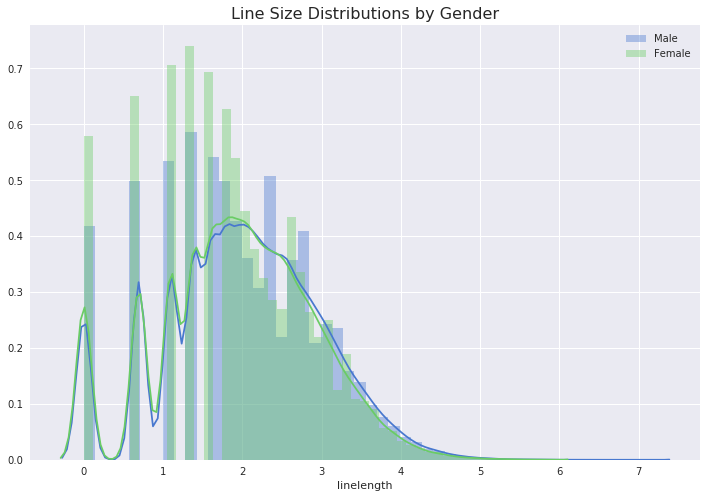

In [102]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style='darkgrid', palette='muted', color_codes=True)
f, axes = plt.subplots(1,1, figsize=(12,8))
plt.title("Line Size Distributions by Gender",fontsize=16)
sns.distplot(np.log(train[train['M']==1]['linelength']),label='Male')
sns.distplot(np.log(train[train['M']==0]['linelength']),label='Female')
#plt.setp(axes, yticks=a)
plt.legend()
plt.plot()